In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
import json
import configparser
from pathlib import Path
import os
import numpy as np

def RMSE(y_real, y_predict):
    return np.sqrt(MSE(y_real, y_predict))

In [6]:
configs = configparser.ConfigParser()
configs.read("../configuracoes.conf",encoding='utf-8')

data_folder = Path(configs["DEFAULT"]["folder_path"])
path = data_folder / configs["DEFAULT"]["file"]
qtd_Meses = int(configs["DEFAULT"]["meses"])
regiao = configs["DEFAULT"]["regiao"]

df = pd.read_excel(path, parse_dates=['ano'])
df.razao = df.razao * 100
train = df.iloc[-12-qtd_Meses::]
train = train.iloc[:-qtd_Meses:]
val = df.iloc[-qtd_Meses::]
val_grafico = df.iloc[-qtd_Meses - 1::]

models = ['RNN', 'LSTM', 'CNN']
resultados = {model:[] for model in models}

for model in models:
    with open(f'previsoes/previsao_{model}_cesta_basica_{regiao}_{qtd_Meses}_meses.json','r') as file:
        resultado = json.load(file)
        resultado['cesta_basica'] = resultado['cesta_basica'].replace("[", "")
        resultado['cesta_basica'] = resultado['cesta_basica'].replace("]", "")
        temp = resultado['cesta_basica'].split(',')
        for valor in temp:
            resultados[model].append(float(valor) * 100)

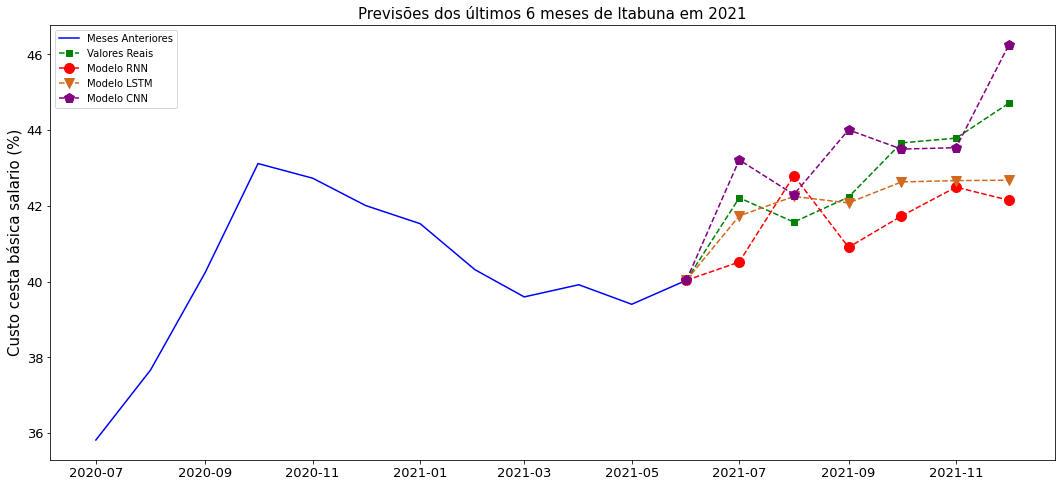

In [7]:
cores = ['red', 'chocolate', 'purple']
markers = ['o', 'v', 'p']

fig, ax = plt.subplots(1,1)
fig.set_figwidth(18)
fig.set_figheight(8)

ax.plot(train.ano.values, train.razao.values, label = 'Meses Anteriores', color = 'blue')
ax.plot(val_grafico.ano.values, val_grafico.razao.values, label = 'Valores Reais', color = 'green', ls ='--', marker='s')
ax.set_ylabel("Custo cesta básica salario (%)", size = 15)

for model, cor, marker in zip(models, cores, markers):
    ax.plot(val_grafico.ano.values, val_grafico.razao[:-qtd_Meses:].values.tolist() + resultados[model],
    label=f'Modelo {model}', color = cor, ls ='--', marker=marker, markersize=10)

plt.xticks(size=13)
plt.yticks(size=13)

plt.title(f"Previsões dos últimos {qtd_Meses} meses de {regiao} em 2021", size=15)
plt.legend(loc='upper left')
plt.savefig(fname=f'models_previsao_{qtd_Meses}_meses_{regiao}_.png')

In [8]:
metrics_index = ['MAE', 'MSE', 'RMSE', 'MAPE(%)']

resultados_metricas = {model:[] for model in models}

for model in models:
    for metric in [MAE, MSE, RMSE, MAPE]:
        if metric == MAPE:
            resultados_metricas[model].append(100 * round(metric(val.razao, resultados[model]), 5))
        else:
            resultados_metricas[model].append(round(metric(val.razao, resultados[model]), 5))

resultados_metricas = pd.DataFrame(resultados_metricas, index=metrics_index).T
resultados_metricas

,MAE,MSE,RMSE,MAPE(%)
RNN,1.67146,3.01424,1.73616,3.867
LSTM,0.91497,1.19255,1.09204,2.097
CNN,0.91038,1.19226,1.09191,2.121
